# IPPR PBL 

**Group Members : Aaryan Kurade, Aditya Deshmukh** <br>
**PRN : 1032222016, 1032212528** <br>
**Date : 20/04/2024** <br>

**Topic : Satellite Image Segmentation** <br>
**Problem Statement : Land Use Land Cover classification Using Satellite Images and Deep Learning** <br>
**Selected Pre-trained Model : VGG16** <br>
**Dataset : https://www.kaggle.com/datasets/apollo2506/eurosat-dataset/data**

In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
dataset_folder = "C:/Users/Aaryan/Videos/Satellite/EuroSAT/"

In [3]:
# column names for DataFrame
column_names = ["id", "path", "class_id", "class_name"]

training_df = pd.read_csv(dataset_folder + "train.csv", names=column_names)
validation_df = pd.read_csv(dataset_folder + "validation.csv", names=column_names)
test_df = pd.read_csv(dataset_folder + "test.csv", names=column_names)

In [4]:
# dataset sizes
dataset_sizes = [len(df) for df in [training_df, validation_df, test_df]]
dataset_labels = ["Training", "Validation", "Test"]
total_dataset_size = sum(dataset_sizes)
for label, size in zip(dataset_labels, dataset_sizes):
    print(f"{label} set size: {size} ({round(size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


In [5]:
image_width, image_height = 64, 64
batch_size = 32

In [7]:
# Create ImageDataGenerators for training, validation, and testing
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.


C:\Users\Aaryan\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 5400 validated image filenames belonging to 10 classes.


C:\Users\Aaryan\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 2700 validated image filenames belonging to 10 classes.


C:\Users\Aaryan\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [12]:
class_name_list = np.array(list(train_generator.class_indices.keys()))
labels, count = np.unique(train_generator.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


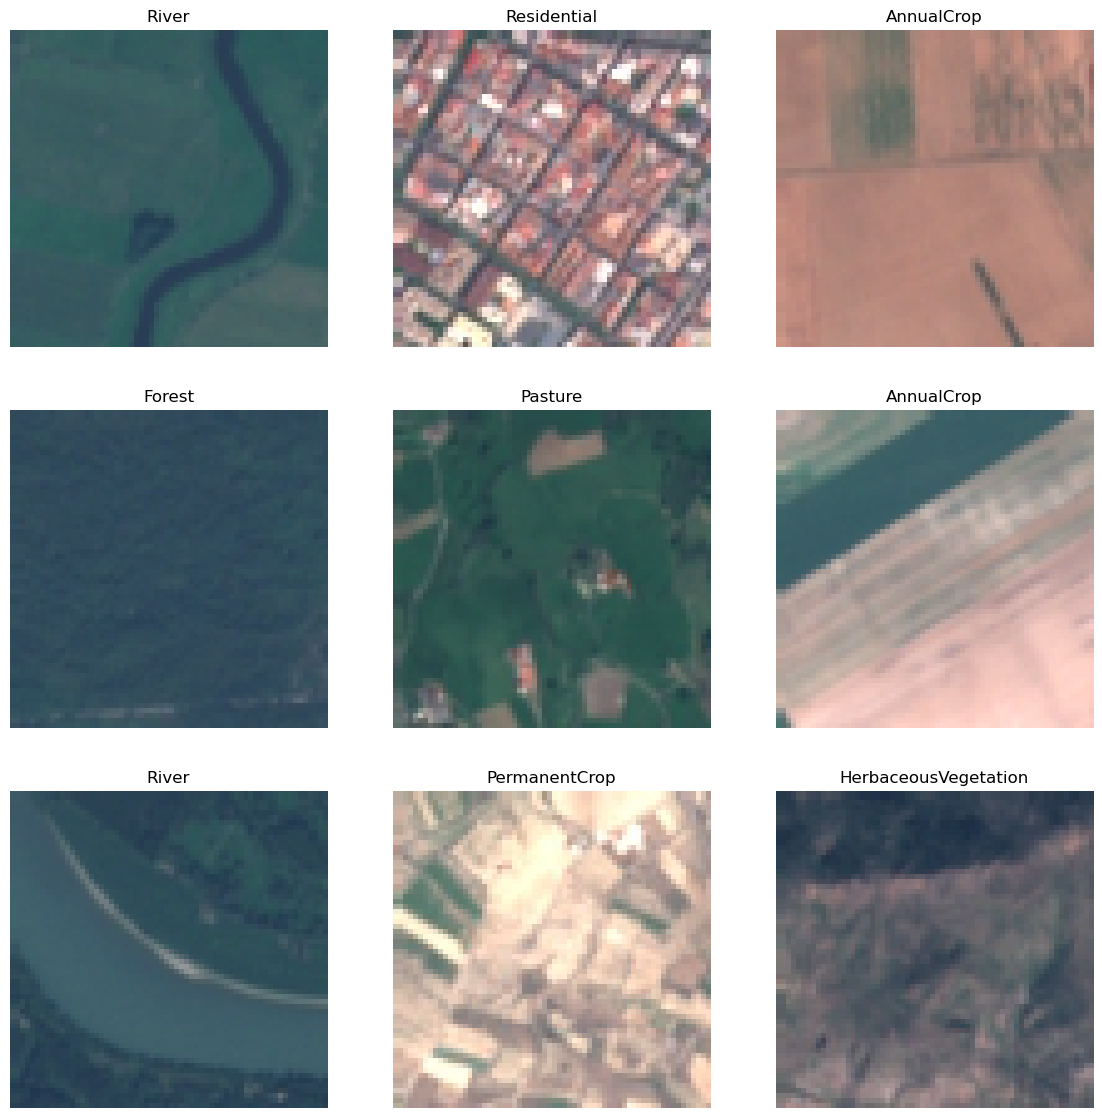

In [17]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

images, class_ids = next(train_generator)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

In [18]:
base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_path = "C:/Users/Aaryan/Videos/Satellite/eurosat_rgb_model.keras"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [21]:
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=1e-4), 
              metrics=["accuracy"])

In [23]:
history = model.fit(train_generator, 
                    validation_data=valid_generator, 
                    epochs=10, 
                    callbacks=callbacks,
                    batch_size=batch_size)

Epoch 1/10


C:\Users\Aaryan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.3279 - loss: 1.8591 - val_accuracy: 0.6696 - val_loss: 1.0829 - learning_rate: 1.0000e-04
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.8123 - loss: 0.6120 - val_accuracy: 0.9200 - val_loss: 0.2573 - learning_rate: 1.0000e-04
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.9281 - loss: 0.2604 - val_accuracy: 0.9239 - val_loss: 0.2609 - learning_rate: 1.0000e-04
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - accuracy: 0.9406 - loss: 0.2139 - val_accuracy: 0.9557 - val_loss: 0.1605 - learning_rate: 1.0000e-04
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 331s 561ms/step - accuracy: 0.9567 - loss: 0.1639 - val_accuracy: 0.9569 - val_loss: 0.1415 - learning_rate: 1.0000e-04
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 352s 595ms/step - accuracy: 0.9620 - loss: 0.1377 - val_accuracy: 0.9519 - val_loss: 0.1609 - learning_rate: 1.0000e-04
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 296s 500ms/step - accu

**The model achieved an accuracy of 95.67% on the training dataset with a corresponding loss of 0.1639.**<br>
**On the validation dataset, the model attained an accuracy of 95.69% with a loss of 0.1415.**<br>
**The learning rate remains constant at 0.0001 throughout this epoch.**<br>

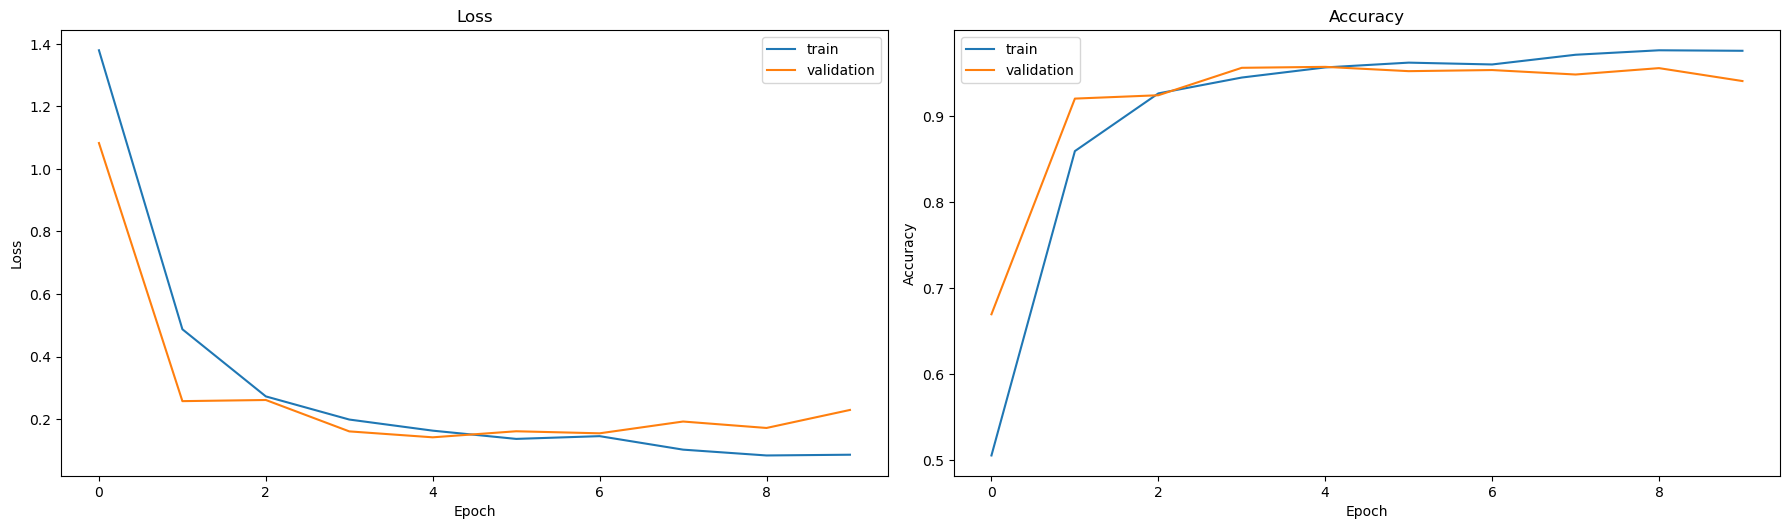

In [24]:
# Plot training history
plt.figure(figsize=(18, 10))

# Loss subplot
plt.subplot(2, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy subplot
plt.subplot(2, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate model on test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9635 - loss: 0.1352
Test Loss: 0.12575079500675201, Test Accuracy: 0.9644444584846497


In [26]:
# Reset test generator and predict labels
test_generator.reset()
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step


In [29]:
predicted_probabilities = model.predict(test_generator, steps=test_generator.n)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step   


C:\Users\Aaryan\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


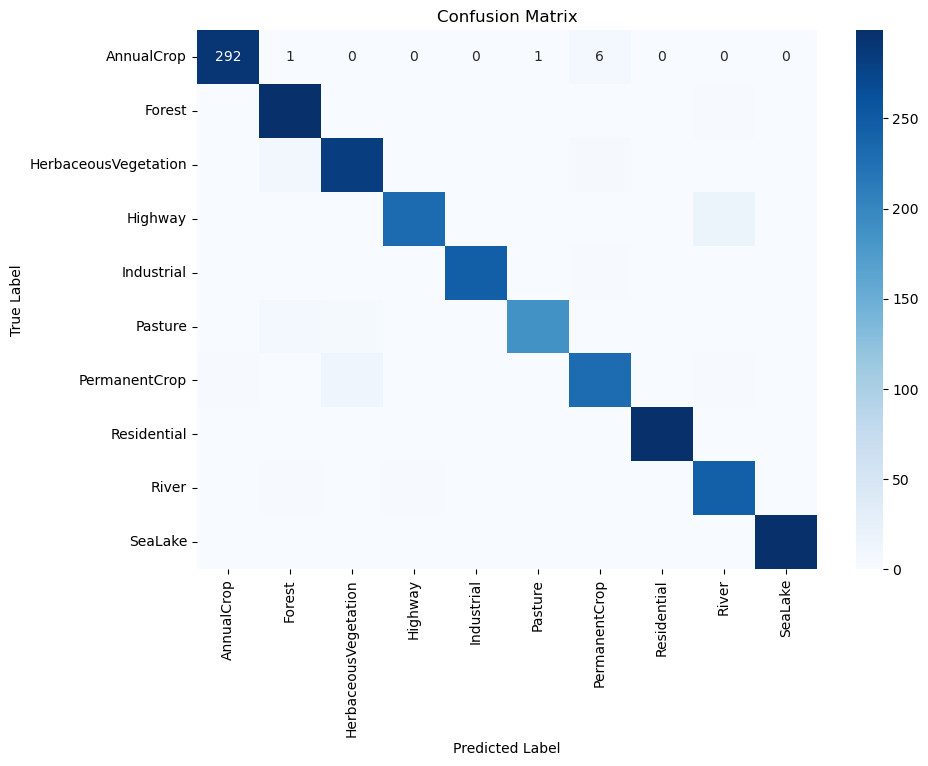

In [30]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
results_df = pd.DataFrame(
    {
        "label": test_generator.labels, 
        "prediction": predicted_class_ids, 
        "path": test_generator.filepaths
    }
)

In [33]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

96 wrong predictions out of 2700


# Conclusion 

In conclusion, our project successfully addressed the task of Land Use Land Cover classification using Satellite Images and Deep Learning, employing the powerful VGG16 pre-trained model. By leveraging state-of-the-art techniques in image segmentation, we were able to accurately classify different land use and land cover categories, providing valuable insights into land management, urban planning, and environmental monitoring. Our approach demonstrates the efficacy of deep learning in analyzing large-scale satellite imagery datasets, paving the way for enhanced decision-making processes in various domains.

# VGG16 Architecture
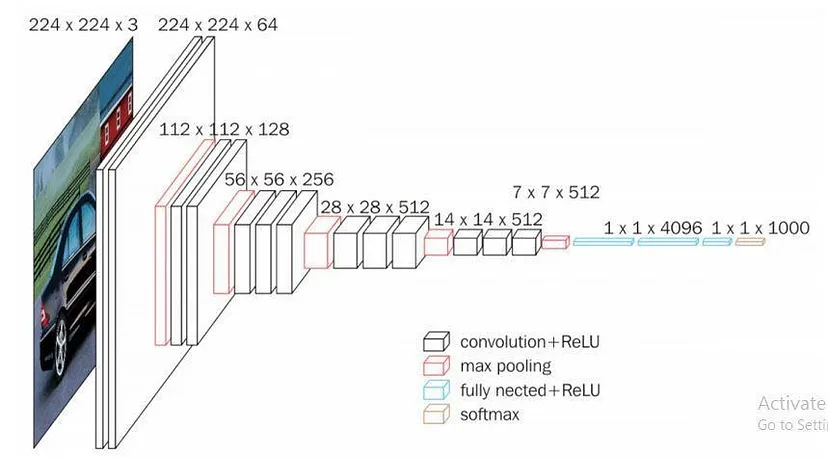
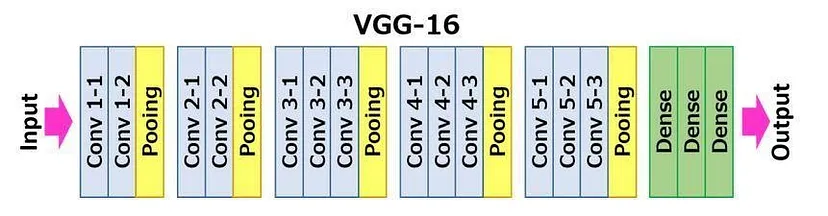

The VGG-16 architecture is a deep convolutional neural network (CNN) designed for image classification tasks. It was introduced by the Visual Geometry Group at the University of Oxford. VGG-16 is characterized by its simplicity and uniform architecture, making it easy to understand and implement.

The VGG-16 configuration typically consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. These layers are organized into blocks, with each block containing multiple convolutional layers followed by a max-pooling layer for downsampling.

Here’s a breakdown of the VGG-16 architecture and its components:

**1) Input Layer:** <br>
Input dimensions: (224, 224, 3) <br>

**2) Convolutional Layers (64 filters, 3×3 filters, same padding):** <br>
Two consecutive convolutional layers with 64 filters each and a filter size of 3×3. <br>
Same padding is applied to maintain spatial dimensions. <br>

**3) Max Pooling Layer (2×2, stride 2):**<br>
Max-pooling layer with a pool size of 2×2 and a stride of 2.<br>

**4) Convolutional Layers (128 filters, 3×3 filters, same padding):**<br>
Two consecutive convolutional layers with 128 filters each and a filter size of 3×3.<br>

**5) Max Pooling Layer (2×2, stride 2):**<br>
Max-pooling layer with a pool size of 2×2 and a stride of 2. <br>

**6) Convolutional Layers (256 filters, 3×3 filters, same padding):**<br>
Two consecutive convolutional layers with 256 filters each and a filter size of 3×3.<br>

**7) Convolutional Layers (512 filters, 3×3 filters, same padding):**<br>
Two sets of three consecutive convolutional layers with 512 filters each and a filter size of 3×3.<br>

**8) Max Pooling Layer (2×2, stride 2):**<br>
Max-pooling layer with a pool size of 2×2 and a stride of 2.<br>

**9) Stack of Convolutional Layers and Max Pooling:**<br>
Two additional convolutional layers after the previous stack.<br>
Filter size: 3×3.<br>

**10) Flattening:**<br>
Flatten the output feature map (7x7x512) into a vector of size 25088.<br>

**11) Fully Connected Layers:**<br>
Three fully connected layers with ReLU activation.<br>
First layer with input size 25088 and output size 4096.<br>
Second layer with input size 4096 and output size 4096.<br>
Third layer with input size 4096 and output size 1000, corresponding to the 1000 classes in the ILSVRC challenge.<br>
Softmax activation is applied to the output of the third fully connected layer for classification.<br>

# VGG16 Summary :
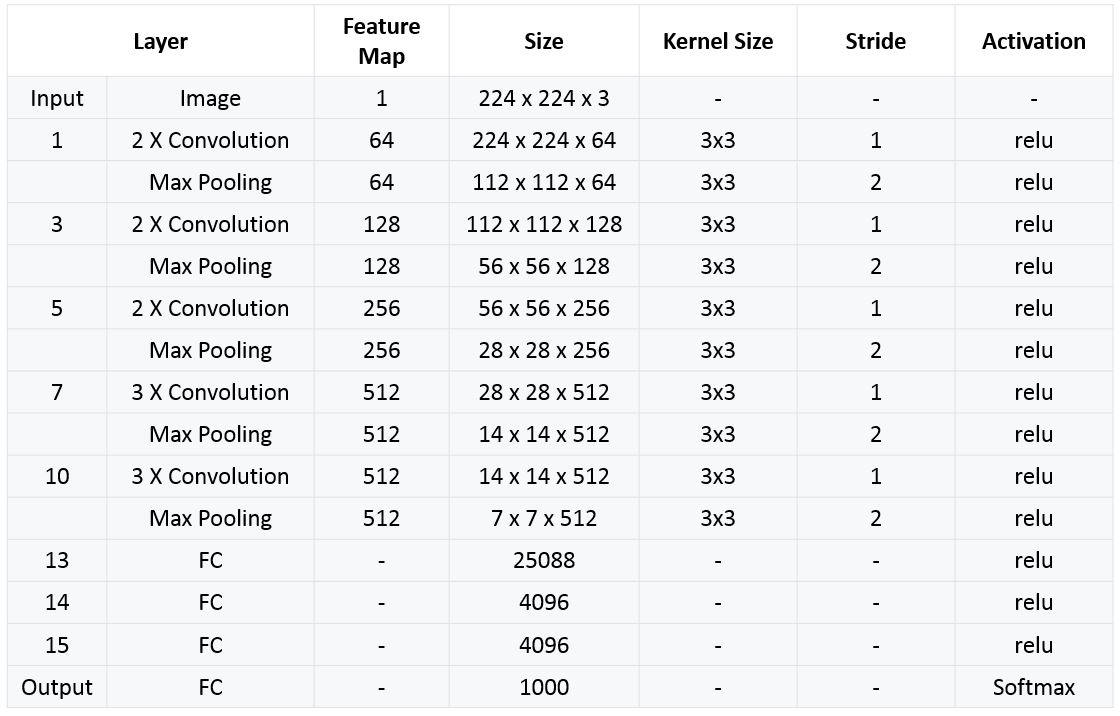

## References :
VGG16 : https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918